In [3]:
import random
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import math
# current distinct shortfalls: reinfection is just as likely as primary infection, graph doesn't visually represent how far connections are

In [88]:
## variables

tot = 500 # number of people
friends = 12 # number of contacts generated for each person; note that we end up with more than tot*friends connections because of lolcode
adoption_p = 0.1 # what fraction of the population has the app
initial_infections = 1 # how many random people are infected before spread
steps = 1 # how many infection steps happen
p_infection = 0.8 # assumption about the probability of getting infected from a single infected contact in 1 time step

duration = 5 # assumption about how long after getting infected you remain infectious; not super relevant


In [126]:
## functions

def infect_step(t):
    print("infected at", t)
    original_infected = {}
    for el in infected:
        original_infected[el] = [0]
        original_infected[el][0] = infected[el][0]
    for person in contacts:
        for friend in contacts[person]:
            if (original_infected[friend][0] > 0):
                r = random.randrange(0, 100)
                if (r < p_infection*100):
                    print(person, "infected by", friend)
                    infected[person][0] = t
        if (t > original_infected[person][0] + duration):
            infected[person][0] = 0
    return(t+1)

def check_add_node(target, graph, origin=0):
    if (origin != 0):
        node_name = str(target) + "-" + str(origin)
    else:
        node_name = str(target)
    if (infected[target][0] > 0):
        if (infected[target][1] > 0):
            graph.add_node(node_name, color = "#F21111")
        else:
            graph.add_node(node_name, color = "#B07676")
    else:
        if (infected[target][1] > 0):
            graph.add_node(node_name, color = "#3AF23A")
        else:
            graph.add_node(node_name, color = "#3F7FBF")
    # print(str(target) + " manifested as", node_name)
    infected[target][2] = node_name
    return(node_name)

def check_add_node_nx(target, graph, origin=0):
    if (origin != 0):
        node_name = str(target) + "-" + str(origin)
    else:
        node_name = str(target)
    if (infected[target][0] > 0):
        if (infected[target][1] > 0):
            graph.add_nodes_from([(node_name, {"color": "#F21111"})])
        else:
            graph.add_nodes_from([(node_name, {"color": "#B07676"})])
    else:
        if (infected[target][1] > 0):
            graph.add_nodes_from([(node_name, {"color": "#3AF23A"})])
        else:
            graph.add_nodes_from([(node_name, {"color": "#3F7FBF"})])
    # print(str(target) + " manifested as", node_name)
    infected[target][2] = node_name
    return(node_name)


def generate_histogram(targets, contacts, app):
    histo = []
    seen = set()
    def walk(layer, depth):
        if (len(layer) == 0):
            return
        next_layer = []
        n_infected = 0
        for target in layer:
            if (target not in seen):
                seen.add(target)
                next_layer += contacts[target]
                if (app == 0):
                    if (infected[target][0] > 0):
                        n_infected += 1
                else:
                    if (infected[target][1] > 0):
                        if (infected[target][0] > 0):
                            n_infected += 1
        histo.append(n_infected)
        walk(next_layer, depth + 1)
        
    walk(targets, 0)
    return histo
    

# def generate_graph2(graph, target, jumps, seen, app):
#     check_add_node(target, graph)
#     def recurse(graph, target, jumps, seen, app):
#         if (jumps < 1):
#             print("--")
#             return(graph)
#         seen2 = set()
#         for el in seen:
#             seen2.add(el)
#         seen2.add(target)
#         for friend in contacts[target]:
#             if (app == 0):
#                 if (friend not in seen):
#                     a = check_add_node(friend, graph, target)
#                     graph.add_edge(infected[target][2], a)

#                     recurse(graph, friend, jumps-1, seen2, app)
#             else:
#                 if (infected[friend][1] > 0):
#                     if (friend not in seen):
#                         a = check_add_node(friend, graph, target)
#                         graph.add_edge(infected[target][2], a)

#                         recurse(graph, friend, jumps-1, seen2, app)
#     recurse(graph, target, jumps, seen, app)
    
def generate_graph_pyvis(target, app):
    graph = Network()
    check_add_node(target, graph)
    seen = set()
    seen.add(target)
    targets = contacts[target]
    origins = []
    for i in range(len(targets)):
        origins.append(target)
    
    def recurse(targets, origins, depth, seen, graph):
        if (len(targets) == 0):
            return
        new_targets = []
        new_origins = []
        k = -1
        for target in targets:
            k += 1
            if target not in seen:
                origin = origins[k]
                seen.add(target)
                check_add_node(target, graph)
                graph.add_edge(infected[target][2], infected[origin][2])
                new_targets += contacts[target]
                for i in range(len(contacts[target])):
                    new_origins.append(target)
        recurse(new_targets, new_origins, depth+1, seen, graph)
    
    recurse(targets, origins, 1, seen, graph)
    return(graph)
                
def generate_graph_nx(target, app):
    graph = nx.Graph()
    check_add_node_nx(target, graph)
    seen = set()
    seen.add(target)
    targets = contacts[target]
    origins = []
    for i in range(len(targets)):
        origins.append(target)
    
    def recurse(targets, origins, depth, seen, graph):
        if (len(targets) == 0):
            return
        new_targets = []
        new_origins = []
        k = -1
        for target in targets:
            k += 1
            if target not in seen:
                origin = origins[k]
                seen.add(target)
                check_add_node_nx(target, graph)
                graph.add_edge(infected[target][2], infected[origin][2])
                new_targets += contacts[target]
                for i in range(len(contacts[target])):
                    new_origins.append(target)
        recurse(new_targets, new_origins, depth+1, seen, graph)
    
    recurse(targets, origins, 1, seen, graph)
    
    result_g = Network(notebook = True)
    result_g.barnes_hut()
    result_g.from_nx(graph)
    
    return(result_g)

def generate_graph(target, app, in_notebook):
    if (in_notebook == 0):
        return generate_graph_pyvis(target, app)
    elif (in_notebook == 1):
        return generate_graph_nx(target, app)
    
print("Functions loaded")

Functions loaded


In [127]:
## setup

contacts = {}
infected = {} # tracks whether you are infected, and if so, when did you get infected, as well as node name # todo rename this?
t1 = 1

# print("Start")

# setup
app_user_n = math.floor(tot * adoption_p)
app_users = set()
app_users.add(0)
for i in range(app_user_n):
    r = random.randrange(tot-1)
    while (r+1 in app_users):
        r = random.randrange(tot-1)
    app_users.add(r+1)

for i in range(tot):
    contacts[i] = []
    if (i in app_users):
        infected[i] = [0, 1, ""] # time of infection, app adoption, node-name
    else:
        infected[i] = [0, 0, ""]

# this generates {friends} connections for each person, meaning that there will be ~1.5x as many connections as there would be with more careful code
for i in range(tot):
    for j in range(friends):
        if (len(contacts[i]) == friends):
            break
        r = random.randrange(tot)
        while (r == i):
            r = random.randrange(tot);
        # print(r, j, i, "--------------")
        # print(r, i, contacts[r], contacts[i])
        if (r not in contacts[i]):
            contacts[i].append(r)
        if (i not in contacts[r]):
            contacts[r].append(i)
        # print(r, i, contacts[r], contacts[i])
        

for i in range(initial_infections):
    r = random.randrange(tot)
    while (infected[r][0] == 1):
        r = random.randrange(tot)
    infected[r][0] = 1
    print(r, "is patient zero")
    
for i in range(steps):
    t1 = infect_step(t1)

infected_n = 0
for el in infected:
    if (infected[el][0] > 0):
        infected_n += 1
print(infected_n, " people are currently infected out of a total of ", tot)

32 is patient zero
infected at 1
5 infected by 32
148 infected by 32
201 infected by 32
219 infected by 32
228 infected by 32
279 infected by 32
326 infected by 32
345 infected by 32
441 infected by 32
465 infected by 32
478 infected by 32
479 infected by 32
13  people are currently infected out of a total of  500


Y data [with app]:          [0, 0, 5, 8, 0, 0]
Y data [regardless of app]: [0, 5, 55, 69, 0, 0]


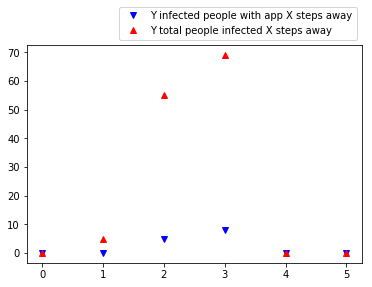

In [82]:
y_axis = generate_histogram([0], contacts, 0)
x_axis = []
y_axis2 = generate_histogram([0], contacts, 1)
x_axis2 = []
for el in range(len(y_axis)):
    x_axis.append(el)
for el in range(len(y_axis2)):
    x_axis2.append(el)
plt.plot(x_axis2, y_axis2, 'vb', label='Y infected people with app X steps away')
plt.plot(x_axis, y_axis, '^r', label='Y total people infected X steps away')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.2))

print("Y data [with app]:         ", y_axis2)
print("Y data [regardless of app]:", y_axis)
plt.show()

In [81]:
# set this to 0 if you want the graph to be opened as a separate html file, which could make for a visually clearer graph
in_notebook = 0

net4 = generate_graph(0, 0, in_notebook)

## uncomment the show_buttons and comment the set_options block if you want to fiddle with the graph's physics
# net4.show_buttons(filter_=['physics'])
net4.set_options(
    """
    var options = {
      "physics": {
        "barnesHut": {
          "centralGravity": 0.3,
          "springLength": 40
        },
        "minVelocity": 0.75
      }
    }
    """
)
name = str(tot) + "-" + str(friends) + "-" + str(int(adoption_p*100)) + "-" + str(initial_infections) + "-" + str(steps) + "-" + str(int(p_infection*100)) + ".html"

net4.show(name)
